# Econométrie - projet

SES722 
27/03/2020
Sonia BOUDEN, Xavier BRACQUART

In [393]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.regression import linear_model as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt # peut nécessiter de revenir à la version 0.10 (avec "pip install statsmodels==0.10")
from statsmodels.tools.tools import add_constant
from scipy.stats import f
from statsmodels.tsa.stattools import grangercausalitytests as granger

# Partie 2. Séries temporelles

## Question 1 

> Importer les données du fichier quarterly.xls (corriger le problème éventuel d’observations manquantes)

In [2]:
df = pd.read_excel("quarterly.xls")
df.head()

,DATE,FFR,Tbill,Tb1yr,r5,r10,PPINSA,Finished,CPI,CPICORE,M1NSA,M2SA,M2NSA,Unemp,IndProd,RGDP,Potent,Deflator,Curr
0,1960Q1,3.93,3.87,4.57,4.64,4.49,31.67,33.20,29.40,18.92,140.53,896.1,299.40,5.13,23.93,2845.3,2824.2,18.521,31.830
1,1960Q2,3.70,2.99,3.87,4.30,4.26,31.73,33.40,29.57,19.00,138.40,903.3,300.03,5.23,23.41,2832.0,2851.2,18.579,31.862
2,1960Q3,2.94,2.36,3.07,3.67,3.83,31.63,33.43,29.59,19.07,139.60,919.4,305.50,5.53,23.02,2836.6,2878.7,18.648,32.217
3,1960Q4,2.30,2.31,2.99,3.75,3.89,31.70,33.67,29.78,19.14,142.67,932.8,312.30,6.27,22.47,2800.2,2906.7,18.700,32.624
4,1961Q1,2.00,2.35,2.87,3.64,3.79,31.80,33.63,29.84,19.17,142.23,948.9,317.10,6.80,22.13,2816.9,2934.8,18.743,32.073


In [3]:
df.isna().sum()

DATE        0
FFR         0
Tbill       0
Tb1yr       0
r5          0
r10         0
PPINSA      0
Finished    0
CPI         0
CPICORE     0
M1NSA       0
M2SA        0
M2NSA       0
Unemp       0
IndProd     0
RGDP        0
Potent      0
Deflator    0
Curr        0
dtype: int64

Le fichier ne présente pas d'observations manquantes.

On transforme le format de la date, et on indique que la date est l'index des données:

In [4]:
df["DATE"] = pd.to_datetime(df["DATE"])
df.set_index("DATE", inplace=True)
df.head()

,FFR,Tbill,Tb1yr,r5,r10,PPINSA,Finished,CPI,CPICORE,M1NSA,M2SA,M2NSA,Unemp,IndProd,RGDP,Potent,Deflator,Curr
DATE,,,,,,,,,,,,,,,,,,
1960-01-01,3.93,3.87,4.57,4.64,4.49,31.67,33.20,29.40,18.92,140.53,896.1,299.40,5.13,23.93,2845.3,2824.2,18.521,31.830
1960-04-01,3.70,2.99,3.87,4.30,4.26,31.73,33.40,29.57,19.00,138.40,903.3,300.03,5.23,23.41,2832.0,2851.2,18.579,31.862
1960-07-01,2.94,2.36,3.07,3.67,3.83,31.63,33.43,29.59,19.07,139.60,919.4,305.50,5.53,23.02,2836.6,2878.7,18.648,32.217
1960-10-01,2.30,2.31,2.99,3.75,3.89,31.70,33.67,29.78,19.14,142.67,932.8,312.30,6.27,22.47,2800.2,2906.7,18.700,32.624
1961-01-01,2.00,2.35,2.87,3.64,3.79,31.80,33.63,29.84,19.17,142.23,948.9,317.10,6.80,22.13,2816.9,2934.8,18.743,32.073


## Question 2

> Stationnariser la série de CPI en utilisant la méthode de régression qui inclue un terme de tendance dont la forme fonctionnelle est à choisir (linéaire, quadratique, log, exponentielle,...)

Le CPI (pour Consumer Price Index) est l'indice des prix à la consommation.

On isole la série de CPI, pour faciliter les traitements ultérieurs. 

In [5]:
cpi = df["CPI"]

On représente la série de CPI actuelle:

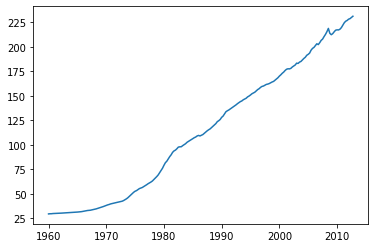

In [6]:
plt.plot(cpi)
plt.show()

Cette série a une tendance dont la forme est proche d'une fonction linéaire.

On entraîne un modèle de régression linéaire OLS. En prenant les résidus du modèle, on obtient la série CPI stationnarisée:

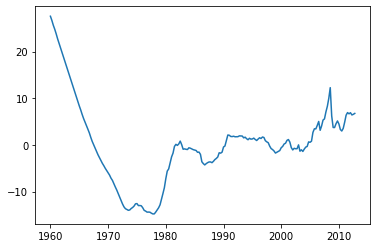

In [179]:
n = len(cpi)
const = np.ones(n)
t = np.arange(1,n+1)
X = np.column_stack((const, t))
y = cpi
model = sm.OLS(y, X)
model = model.fit()
cpi_statio_1 = model.resid
plt.plot(cpi_statio_1)
plt.show()

La courbe évolue bien désormais autour de l'axe des abscisses ; elle a perdu sa tendance temporelle.

TODO: commenter (cf https://fr.wikipedia.org/wiki/Stationnarit%C3%A9_d%27une_s%C3%A9rie_temporelle)

## Question 3

> Stationnariser la série de CPI en utilisant un moyenne mobile centrée 5x5.

On calcule la moyenne mobile centrée d'ordre 5, que l'on soustrait à la série CPI, pour la stationnariser:

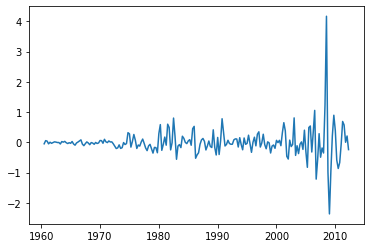

In [8]:
cpi_moving_average_2 = cpi.rolling(window=5, center=True).mean()
cpi_statio_2 = cpi - cpi_moving_average_2
plt.plot(cpi_statio_2)
plt.show()

La courbe a une évolution plus stable qu'avec la méthode de stationnarisation précédente, et une amplitude plus faible. Cette méthode de stationnarisation est meilleure.

## Question 4

> Calculer inf, le taux d’inflation à partir de la variable CPI. Faire un graphique dans le temps de inf. Commentez.

Le taux d'inflation est calculé de la façon suivante à partir de l'IPC:
    
$$
f_{inflation}(t) = \frac{f_{ICP}(t) - f_{ICP}(t-1)}{f_{ICP}(t-1)}
$$

In [361]:
inf = (cpi - cpi.shift(1))/cpi.shift(1)
inf = inf[1:] # On ne prend pas en compte la première ligne de inf, qui est nulle
inf.index = inf.index.to_period('D') # On précise la fréquence explicitement (pour certaines fonctions de statsmodels)

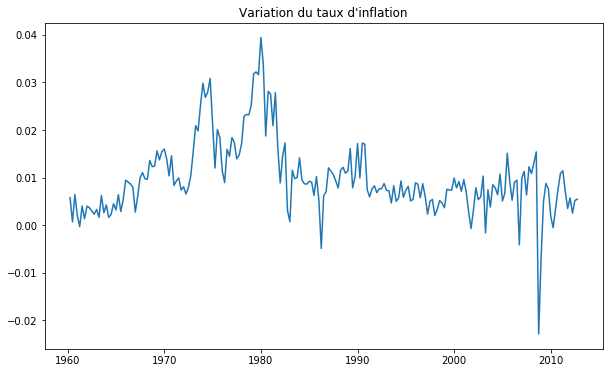

In [365]:
plt.figure(figsize=(10,6))
plt.plot(df.index[1:], list(inf))
plt.title("Variation du taux d'inflation")
plt.show()

TODO: commenter

## Question 5

> Interpréter l'autocorrélogramme et l'autocorrélogramme partiel de inf. Quelle est la différence entre ces deux graphiques

On trace l'autocorrélogramme et l'autocorrélogramme partiel de inf.

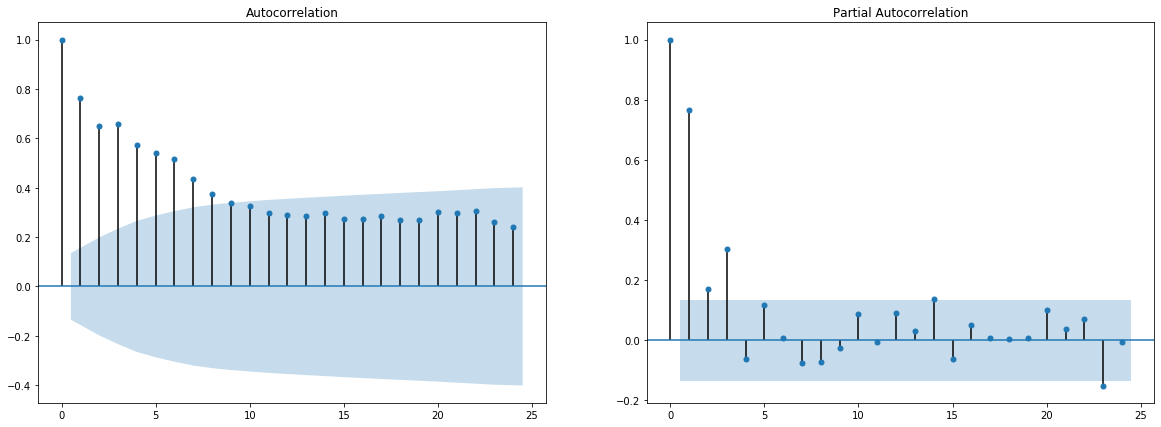

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))

fig = plot_acf(inf, ax=axes[0]) 
fig = plot_pacf(inf, ax=axes[1])

L'**autocorrélation** d'un signal stationnaire (ici le taux d'inflation). Il résulte de la corrélation du signal par lui-même. Il montre la corrélation des observations entre elles, pour un décalage donné en abscisse.
On voit ici que l'autocorrélation est forte entre des observations proches et diminue lorsque les observations sont éloignées.

L'**autocorrélation partielle** est la corrélation entre des observations deux à deux d'un signal stationnaire, avec les observations intermédiaires retirées, pour ne pas influencer le comportement de ces deux observations entre elles.

## Question 6

> Quelle est la différence entre la stationnarité et l'ergodicité ? Pourquoi a-t-on besoin de ces deux conditions. Expliquez le terme "spurious regression".

La **stationnarité** désigne le fait qu'une série temporelle évolue avec le temps, c'est à dire qu'elle suit une structure dépendant du temps.


L'**ergodicité** désigne le fait que les moyennes temporelles sont identiques aux moyennes statistiques, ce qui permet de connaître entièrement la statistique à partir d'une seule réalisation.

spurious regression

TODO: A finir

## Question 7

> Faire le test Augmented Dickey Fuller pour inf en utilisant le critère AIC pour déterminer le nombre de lags à inclure. Commenter

Le test de Dickey-Fuller augmenté peut être utilisé pour tester une racine unitaire dans un processus univarié en présence d'une corrélation en série.

On utilise la fonction `adfuller` de `statsmodels` pour réaliser ce test, avec autolag="AIC" pour laisser l'algorithme déterminer le nombre de lags à inclure.

In [24]:
adf_inf_aic = adfuller(inf, autolag="AIC")
print(adf_inf_aic)

(-2.9190558143371637, 0.04317651687155481, 2, 208, {'1%': -3.4621857592784546, '5%': -2.875537986778846, '10%': -2.574231080806213}, -1519.2580655612676)


Nous obtenons le résultat suivant:
    - Nombre de lags utilisés: 2
    - Statistique de test, adf = -2.92
    - p-value = 0.043
    - Nombre d'observations utilisées = 2018
    - Valeurs critiques pour le test statistique, à hauteur de:
        - 1% : -3.46
        - 5% : -2.88
        - 10% : - 2.57

## Question 8

> Proposer une modélisation AR(p) de inf, en utilisant tous les outils vus au cours.

On définit un modèle autorégressif AR, avec un lag allant de 1 à 20, pour sélectionner le meilleur. On teste le modèle selon le critère AIC et BIC, pour disposer de deux référenciels:

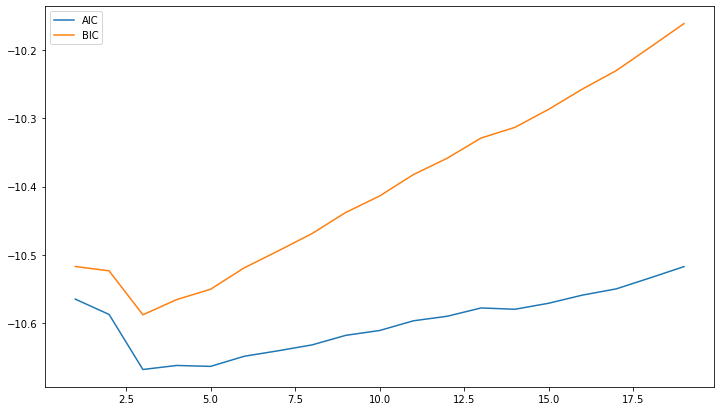

Lag optimal selon le critère BIC: 3
Lag optimal selon le critère AIC: 3


In [79]:
AIC = []
BIC = []

for lag in range(1, 20):
    ar_model = smt.AR(inf).fit(maxlag=lag)
    
    AIC.append(ar_model.aic)
    BIC.append(ar_model.bic)

plt.figure(figsize=(12, 7))
plt.plot(range(1, 20), AIC, label="AIC")
plt.plot(range(1, 20), BIC, label='BIC')
plt.legend()
plt.show()

print("Lag optimal selon le critère BIC: {:d}".format(np.argmin(BIC) + 1))
print("Lag optimal selon le critère AIC: {:d}".format(np.argmin(AIC) + 1))

Le critère AIC est minimisé pour une valeur de **p valant 3**.

## Question 9

> Estimer le modèle de la courbe de Philips qui explique le taux de chômage (Unemp) en fonction du taux d’inflation courant et une constante.

On estime la courbe avec une régression linéaire, qui semble être le modèle le plus proche de la répartition des données.

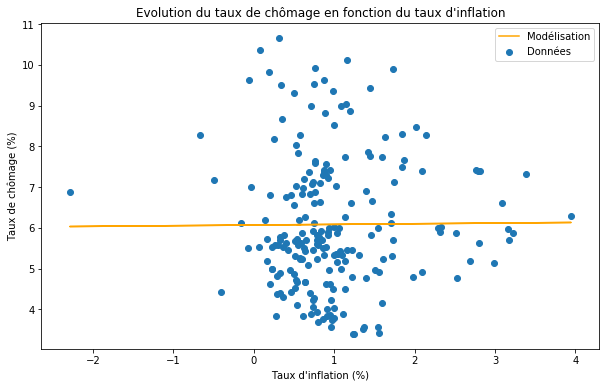

In [204]:
X0 = list(inf*100)
# On ajoute une constante à l'inflation
X = add_constant(X0)
y = df[1:]["Unemp"]

model = sm.OLS(y, X)
model = model.fit()
y_plot = model.predict(X)

plt.figure(figsize=(10,6))
plt.plot(X0, y_plot, color="orange", label="Modélisation")
plt.scatter(X0, y, label="Données")
plt.xlabel("Taux d'inflation (%)")
plt.ylabel("Taux de chômage (%)")
plt.title("Evolution du taux de chômage en fonction du taux d'inflation")
plt.legend()
plt.show()

## Question 10

> Tester l’autocorrélation des erreurs.

On affiche la répartition des erreurs:

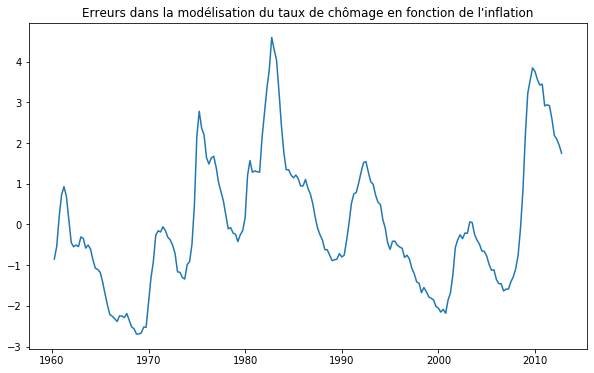

In [200]:
errors = model.resid
plt.figure(figsize=(10,6))
plt.plot(errors)
plt.title("Erreurs dans la modélisation du taux de chômage en fonction de l'inflation")
plt.show()

On affiche l'autocorrélogramme et l'autocorrélogramme partiel:

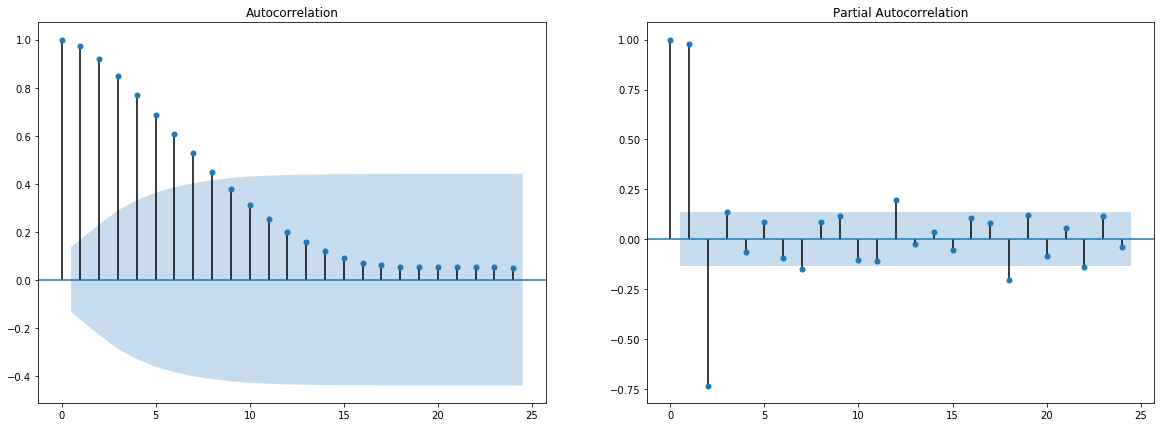

In [203]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))

fig = plot_acf(errors, ax=axes[0]) 
fig = plot_pacf(errors, ax=axes[1])

La courbe de l'autocorrélation est positive et élevée lorsque les valeurs sont proches. Les erreurs sont donc autocorrélées.

## Question 11

> Corriger l’autocorrélation des erreurs par la méthode vue en cours.

In [248]:
# On calcule à l'aide d'un modèle, le coefficient linéaire de corrélation entre erreurs
y = errors.values[1:]
X = errors.shift(1)[1:].values

model = sm.OLS(y, X).fit()
coef = model.params[0]
print(coef)


# On modifie le taux de chômage et l'inflation à partir de ce coefficient
unemp = df[1:]["Unemp"]
inf_correction = np.zeros(len(inf)) 
unemp_correction = np.zeros(len(inf)) 
inf_correction[0] = np.sqrt(1 - coef**2) * inf[0]
unemp_correction[0] = np.sqrt(1 - coef**2) * unemp[0]
for i in range(1, len(df[1:]["Unemp"])):
    unemp_correction[i] = unemp[i] - r * unemp[i-1]
    inf_correction[i] = inf[i] - r * inf[i-1]

    
# On recalcule le taux de chômage en fonction du taux d'inflation, puis on extrait les résidus du modèle
model_correction = sm.OLS(unemp_correction, add_constant(inf_correction)).fit()
errors_correction = model_correction.resid

0.9799237799707919


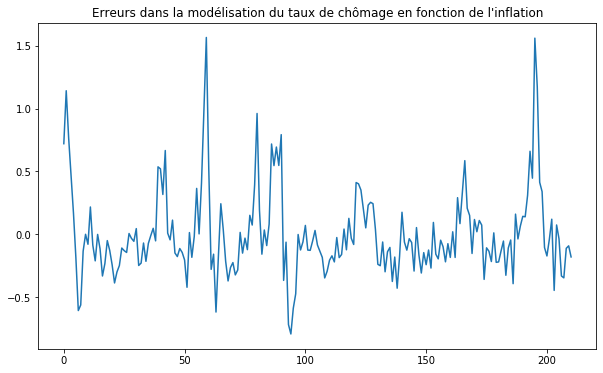

In [249]:
plt.figure(figsize=(10,6))
plt.plot(list(errors_correction))
plt.title("Erreurs dans la modélisation du taux de chômage en fonction de l'inflation")
plt.show()

Les erreurs sont plus faibles et davantage réparties.

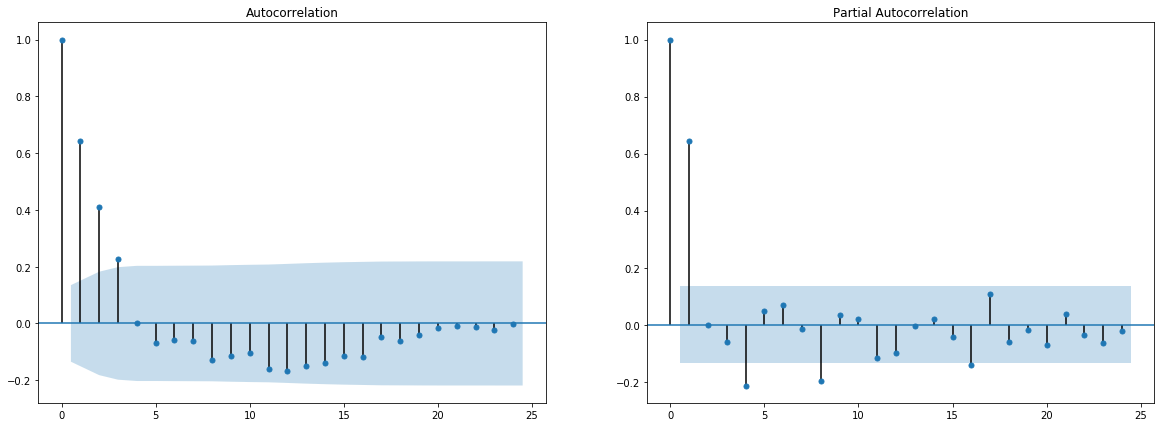

In [251]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))

fig = plot_acf(errors_correction, ax=axes[0]) 
fig = plot_pacf(errors_correction, ax=axes[1])

L'autocorrélation des erreurs a été en grande partie diminuée. On gardera ces variables pour la suite.

## Question 12

> Tester la stabilité de la relation chômage-inflation sur deux sous-périodes de taille identique.

On prend deux sous-périodes de taille 100:

In [284]:
X = list(inf_correction*100)[:200]
X_all = add_constant(X)
y_all = unemp_correction[:200]

X = list(inf_correction*100)[:100]
X1 = add_constant(X)
y1 = unemp_correction[:100]

X = list(inf_correction*100)[100:200]
X2 = add_constant(X)
y2 = unemp_correction[100:200]

On affiche les statistiques descriptives de la relation chômage-inflation sur ces deux sous-périodes:

In [262]:
model = sm.OLS(y1, X1).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     10.50
Date:                Wed, 01 Apr 2020   Prob (F-statistic):            0.00163
Time:                        15:39:04   Log-Likelihood:                -48.487
No. Observations:                 100   AIC:                             101.0
Df Residuals:                      98   BIC:                             106.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1655      0.040      4.166      0.0

In [263]:
model = sm.OLS(y2, X2).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                  0.002176
Date:                Wed, 01 Apr 2020   Prob (F-statistic):              0.963
Time:                        15:39:06   Log-Likelihood:                -17.176
No. Observations:                 100   AIC:                             38.35
Df Residuals:                      98   BIC:                             43.56
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1418      0.029      4.884      0.0

Les statistiques varient entre les deux modèles, notamment le coefficient, la variance et t.

On va maintenant réaliser un test de Chow pour tester la stabilité de la relation. Pour cela on commence par calculer la sommes des carrés des erreurs de plusieurs modèles:

In [299]:
# Modèle non contraint
model = sm.OLS(y_all, X_all).fit()
u = model.resid
SSR_all = u.T @ u
size_all = len(X_all) - 2

# Modèle contraint (première sous-période)
model = sm.OLS(y1, X1).fit()
u = model.resid
SSR1 = u.T @ u
size1 = len(X1) - 2

# Modèle contraint (deuxième sous-période)
model = sm.OLS(y2, X2).fit()
u = model.resid
SSR2 = u.T @ u
size2 = len(X2) - 2

On calcule la p-valeur avec la statistique de Fischer:

In [350]:
F = ((SSR_all - (SSR1 + SSR2)) / (size_all - (size1 + size2))) / ((SSR1 + SSR2) / (size1 + size2))
p_val = f.sf(F, size_all - (size1 + size2), (size1 + size2))

print("Statistique de test : {:0.5f}".format(F))
print("p-valeur            : {:0.5f}".format(p_val))

Statistique de test : 4.22402
p-valeur            : 0.01599


La p-valeur est de 1,5%, ce qui est inférieur à 5%.<br />
On rejette donc l'hypothèse de stabilité entre les 2 sous-périodes, à hauteur de 5%.

## Question 13

> Faites les tests changement de structure de Chow et détecter le point de rupture.

Pour détecter le point de rupture, nous allons calculer la statistique de test et la p-valeur en chaque point. On commence par créer une fonction contenant le calcul du test de Chow, comme au dessus:

In [366]:
def chow_calculation(current_date):
    # Modèle non contraint
    X = list(inf_correction)
    X_all = add_constant(X)
    y_all = unemp_correction
    model = sm.OLS(y_all, X_all).fit()
    u = model.resid
    SSR_all = u.T @ u
    size_all = len(X_all) - 2

    # Modèle contraint (première sous-période)
    X = list(inf_correction)[:current_date]
    X1 = add_constant(X)
    y1 = unemp_correction[:current_date]
    model = sm.OLS(y1, X1).fit()
    u = model.resid
    SSR1 = u.T @ u
    size1 = len(X1) - 2

    # Modèle contraint (deuxième sous-période)
    X = list(inf_correction)[current_date:]
    X2 = add_constant(X)
    y2 = unemp_correction[current_date:]
    model = sm.OLS(y2, X2).fit()
    u = model.resid
    SSR2 = u.T @ u
    size2 = len(X2) - 2

    F = ((SSR_all - (SSR1 + SSR2)) / (size_all - (size1 + size2))) / ((SSR1 + SSR2) / (size1 + size2))
    p_val = f.sf(F, size_all - (size1 + size2), (size1 + size2))
    return F, p_val

In [367]:
Fs = []
p_values = []

# On parcourt nos valeurs avec un taux de trim de 10% aux extrémités
for i in np.arange(int(0.1*len(inf)), int(0.9*len(inf))):
    F, p_val = chow_calculation(i)
    Fs.append(F)
    p_values.append(p_val)

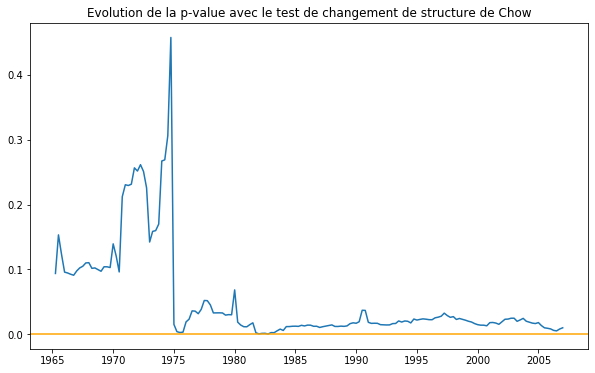

In [374]:
plt.figure(figsize=(10,6))
plt.plot(df.index[int(0.1*len(inf)): int(0.9*len(inf))], p_values)
plt.axhline(min(p_values), color="orange")
plt.title("Evolution de la p-value avec le test de changement de structure de Chow")
plt.show()

Il y a un point de rupture en 1975. Avant cette période, la relation chômage - inflation variait beaucoup. Elle est ensuite devenue beaucoup plus stable.<br />
La courbe orange montre la valeur minimale prise par la p-value, en 1977 et 1982.

## Question 14

> Estimer la courbe de Philips en supprimant l'inflation courante des variables explicatives mais en ajoutant les délais d’ordre 1, 2, 3 et 4 de l’inflation et du chômage. Faire le test de Granger de non causalité de l’inflation sur le chômage. Donnez la p-valeur.

In [375]:
var_delays = []

for row in range(5, len(inf_correction)) :
    var_delays.append([inf_correction[-1], inf_correction[-2], inf_correction[-3], inf_correction[-4],
                      unemp_correction[-1], unemp_correction[-2], unemp_correction[-3], unemp_correction[-4]])

#var_delays = pd.DataFrame(var_delays)

In [411]:
X = add_constant(var_delays) # adding a constant
model = sm.OLS(unemp_correction[5:], X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                      -inf
Date:                Wed, 01 Apr 2020   Prob (F-statistic):                nan
Time:                        18:45:18   Log-Likelihood:                -66.020
No. Observations:                 206   AIC:                             134.0
Df Residuals:                     205   BIC:                             137.4
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0007      0.000      5.416      0.0

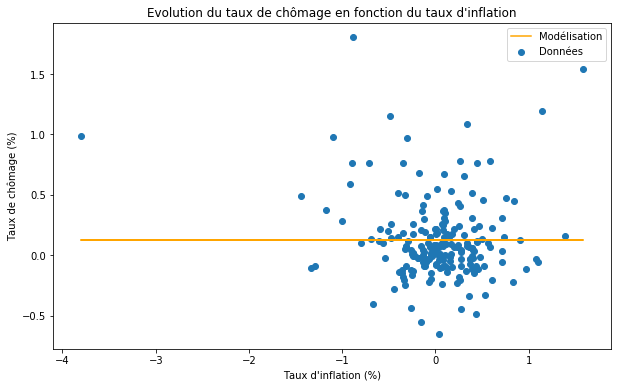

In [412]:
y_plot = model.predict(X)

plt.figure(figsize=(10,6))
plt.plot(inf_correction[5:]*100, y_plot, color="orange", label="Modélisation")
plt.scatter(inf_correction[5:]*100, unemp_correction[5:], label="Données")
plt.xlabel("Taux d'inflation (%)")
plt.ylabel("Taux de chômage (%)")
plt.title("Evolution du taux de chômage en fonction du taux d'inflation")
plt.legend()
plt.show()

In [419]:
granger([unemp_correction, inf_correction], maxlag=4, verbose=True)

ValueError: Insufficient observations. Maximum allowable lag is -1

## Question 15

> Représentez graphiquement les délais distribués et commentez. Calculer l’impact à long de terme de l’inflation sur le chômage.

In [422]:
X = add_constant(var_delays[0:4]) # adding a constant
model = sm.OLS(unemp_correction[5:], X).fit()

print(model.summary())

ValueError: endog and exog matrices are different sizes

## Brouillon:

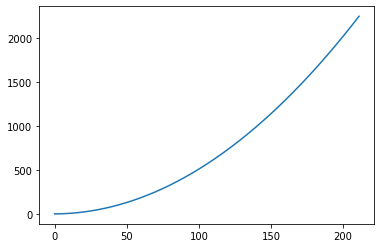

In [12]:
t = (0.05*np.arange(1,n+1)**2)
plt.plot(t)